# 今回の取り組み

**Tyr01%でなぞのエラーが出たので動作確認をします**

In [ ]:
%%bash
# さっそくテスト…
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 74, in main
    args.handler(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 37, in batchmode
    batch.batch_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/batch.py", line 77, in batch_execute
    core_execute.execute_sample(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 114, in add_labels
    mutation_score = make_score(cssplits_control, cssplits_sample)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/make_score.py", line 101, in make_score
    percent_control = call_percent(co

CalledProcessError: Command 'b'# \xe3\x81\x95\xe3\x81\xa3\xe3\x81\x9d\xe3\x81\x8f\xe3\x83\x86\xe3\x82\xb9\xe3\x83\x88\xe2\x80\xa6\nrm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01\ntime DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv\n'' returned non-zero exit status 1.

## いつものセットアップ

In [2]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [3]:
%%bash
# pipの更新
pip install -qU pip
pip install -qU -r requirements.txt

# 実験

In [5]:
%%bash

rm -rf DAJINResults/single_tyr_01 DAJINResults/.tempdir/single_tyr_01 &&
pip install -qe . &&
DAJIN2 \
    --name single_tyr_01 \
    --sample "misc/data/tyr_albino_01%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 12, in single_execute
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 114, in add_labels
    mutation_score = make_score(cssplits_control, cssplits_sample)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/make_score.py", line 101, in make_score
    percent_control = call_percent(counts_control)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/make_score.py", li

CalledProcessError: Command 'b'\nrm -rf DAJINResults/single_tyr_01 DAJINResults/.tempdir/single_tyr_01 &&\npip install -qe . &&\nDAJIN2 \\\n    --name single_tyr_01 \\\n    --sample "misc/data/tyr_albino_01%.fq.gz" \\\n    --control "misc/data/tyr_control.fq.gz" \\\n    --allele "misc/data/tyr_control.fasta" \\\n    --genome mm10\n'' returned non-zero exit status 1.

- singleモードでもエラーが再現しました

In [6]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report
from DAJIN2.core.clustering import clustering

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_01%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single_tyr_10",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single_tyr_10...


In [7]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


preprocessing...


In [8]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [9]:
print(MUTATION_LOCI.keys())

dict_keys(['control'])


In [10]:
print(len(MUTATION_LOCI))
print(MUTATION_LOCI)

1
defaultdict(<class 'set'>, {'control': set()})


In [11]:
########################################################################
# Classify alleles
########################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)


Classify...


In [12]:
classif_sample[0]

{'QNAME': '00065440-7084-4c4f-ada8-9eab3ba17263',
 'RNAME': 'control',
 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=

In [13]:
####################################################################################
# Clustering
####################################################################################
print("Clustering...")

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

Clustering...


IndexError: list index out of range

- `MUTATION_LOCI`が`set()`なのはおかしい！
- でも仮に`MUTATION_LOCI`が空であったときの対応も必須！

ということで、`MUTATION_LOCI`が空であったときの対応として、「その場合にはすべてのリードにLABEL=1を加えるコード」を`add_labels`に追加します


In [15]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


# def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
#     cssplits_mutation = []
#     for cssplits in cssplits_sample:
#         cs_mutation = []
#         for i, cs in enumerate(cssplits):
#             if i in mutation_loci:
#                 cs_mutation.append(cs)
#         cssplits_mutation.append(cs_mutation)
#     return cssplits_mutation


def annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


# def annotate_score(cssplits: list[list], mutation_loci: set, mutation_score: list[dict]):
#     scores = []
#     for cssplit in cssplits:
#         score = [0]
#         for i in range(1, len(cssplit) - 1):
#             if not i in mutation_loci:
#                 score.append(0)
#                 continue
#             kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
#             score.append(mutation_score[i].get(kmer, 0))
#         scores.append(score + [0])
#     return scores


def reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    # paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
    # cssplits_control_by_alleles = defaultdict(list)
    # for path_midsv in paths_midsv:
    #     midsv_control = midsv.read_jsonl(path_midsv)
    #     allele = path_midsv.stem.split("_")[-1]
    #     cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    #     cssplits_control_by_alleles[allele] = cssplits
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: set = MUTATION_LOCI[allele]
        if mutation_loci == set():
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # cssplits_control = replace_both_ends_n(cssplits_control)
        # cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [16]:
clust_sample = add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)

In [17]:
clust_sample[0]

{'QNAME': '00065440-7084-4c4f-ada8-9eab3ba17263',
 'RNAME': 'control',
 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=

- ⬜ `MUTATION_LOCI`が`set()`なのはおかしい！
- ✅ でも仮に`MUTATION_LOCI`が空であったときの対応も必須！

次は`MUTATION_LOCI`が空の理由を探します

In [20]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path

import midsv


def _calc_percent_indels(cssplits):
    percelt_indels = []
    cssplits_transposed = [list(t) for t in zip(*cssplits)]
    for cssplit in cssplits_transposed:
        coverage = 0
        count_indelsub = {"ins": 0, "del": 0, "sub": 0}
        for cs in cssplit:
            if cs == "N":
                continue
            coverage += 1
            if cs.startswith("+"):
                count_indelsub["ins"] += 1
            elif cs.startswith("-"):
                count_indelsub["del"] += 1
            elif cs.startswith("*"):
                count_indelsub["sub"] += 1
        if coverage == 0:
            per_indels = {"ins": 0, "del": 0, "sub": 0}
        else:
            per_indels = {mutation: (count / coverage * 100) for mutation, count in count_indelsub.items()}
        percelt_indels.append(per_indels)
    return percelt_indels


def _extract(cssplits_sample, cssplits_control) -> set():
    percent_sample = _calc_percent_indels(cssplits_sample)
    percent_control = _calc_percent_indels(cssplits_control)
    mutation_loci = set()
    for i, (samp, cont) in enumerate(zip(percent_sample, percent_control)):
        for mutation_type in ["ins", "del", "sub"]:
            if i in mutation_loci:
                break
            if abs(samp[mutation_type] - cont[mutation_type]) > 1:
                mutation_loci.add(i)
    return mutation_loci


###############################################################################


def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME:str) -> defaultdict(set):
    mutation_loci = defaultdict(set)
    for allele in FASTA_ALLELES.keys():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        mutation_loci[allele] = _extract(cssplits_sample, cssplits_control)
    return mutation_loci


In [21]:
allele="control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
mutation_loci = _extract(cssplits_sample, cssplits_control)

In [22]:
print(mutation_loci)

set()


In [23]:
percent_sample = _calc_percent_indels(cssplits_sample)
percent_control = _calc_percent_indels(cssplits_control)
print(percent_sample[828])
print(percent_control[828])

{'ins': 0.0, 'del': 0.13011710539485538, 'sub': 1.131017916124512}
{'ins': 0.0, 'del': 0.13013013013013014, 'sub': 0.15015015015015015}


In [24]:
def _extract(cssplits_sample, cssplits_control) -> set():
    percent_sample = _calc_percent_indels(cssplits_sample)
    percent_control = _calc_percent_indels(cssplits_control)
    mutation_loci = set()
    for i, (samp, cont) in enumerate(zip(percent_sample, percent_control)):
        for mutation_type in ["ins", "del", "sub"]:
            if i in mutation_loci:
                break
            if abs(samp[mutation_type] - cont[mutation_type]) > 0.5:
                mutation_loci.add(i)
    return mutation_loci


In [25]:
allele="control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
mutation_loci = _extract(cssplits_sample, cssplits_control)
print(mutation_loci)

{828}


⬆⬆⬆ `extract_mutation_loci._extract`の閾値を`1`から`0.5%`に下げたことにより目的の変異が抽出できました

- ということで、再度batchをテストします

In [26]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 74, in main
    args.handler(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 37, in batchmode
    batch.batch_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/batch.py", line 77, in batch_execute
    core_execute.execute_sample(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 119, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 55, in annotate_score
    mutation = list(mutscore.ke

CalledProcessError: Command 'b'rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01\ntime DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv\n'' returned non-zero exit status 1.

- エラーが出ました…！一体なぜ…
- いったん、1%のSingleモードを試します

# 👌👌👌 いまここ 👌👌👌

In [27]:
%%bash

rm -rf DAJINResults/single_tyr_01 DAJINResults/.tempdir/single_tyr_01 &&
pip install -qe . &&
DAJIN2 \
    --name single_tyr_01 \
    --sample "misc/data/tyr_albino_01%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single_tyr_01 to see the report.


- あれれ、予想外にSingleモードでエラーなしに終了しました
- 内容も完璧でした…!!

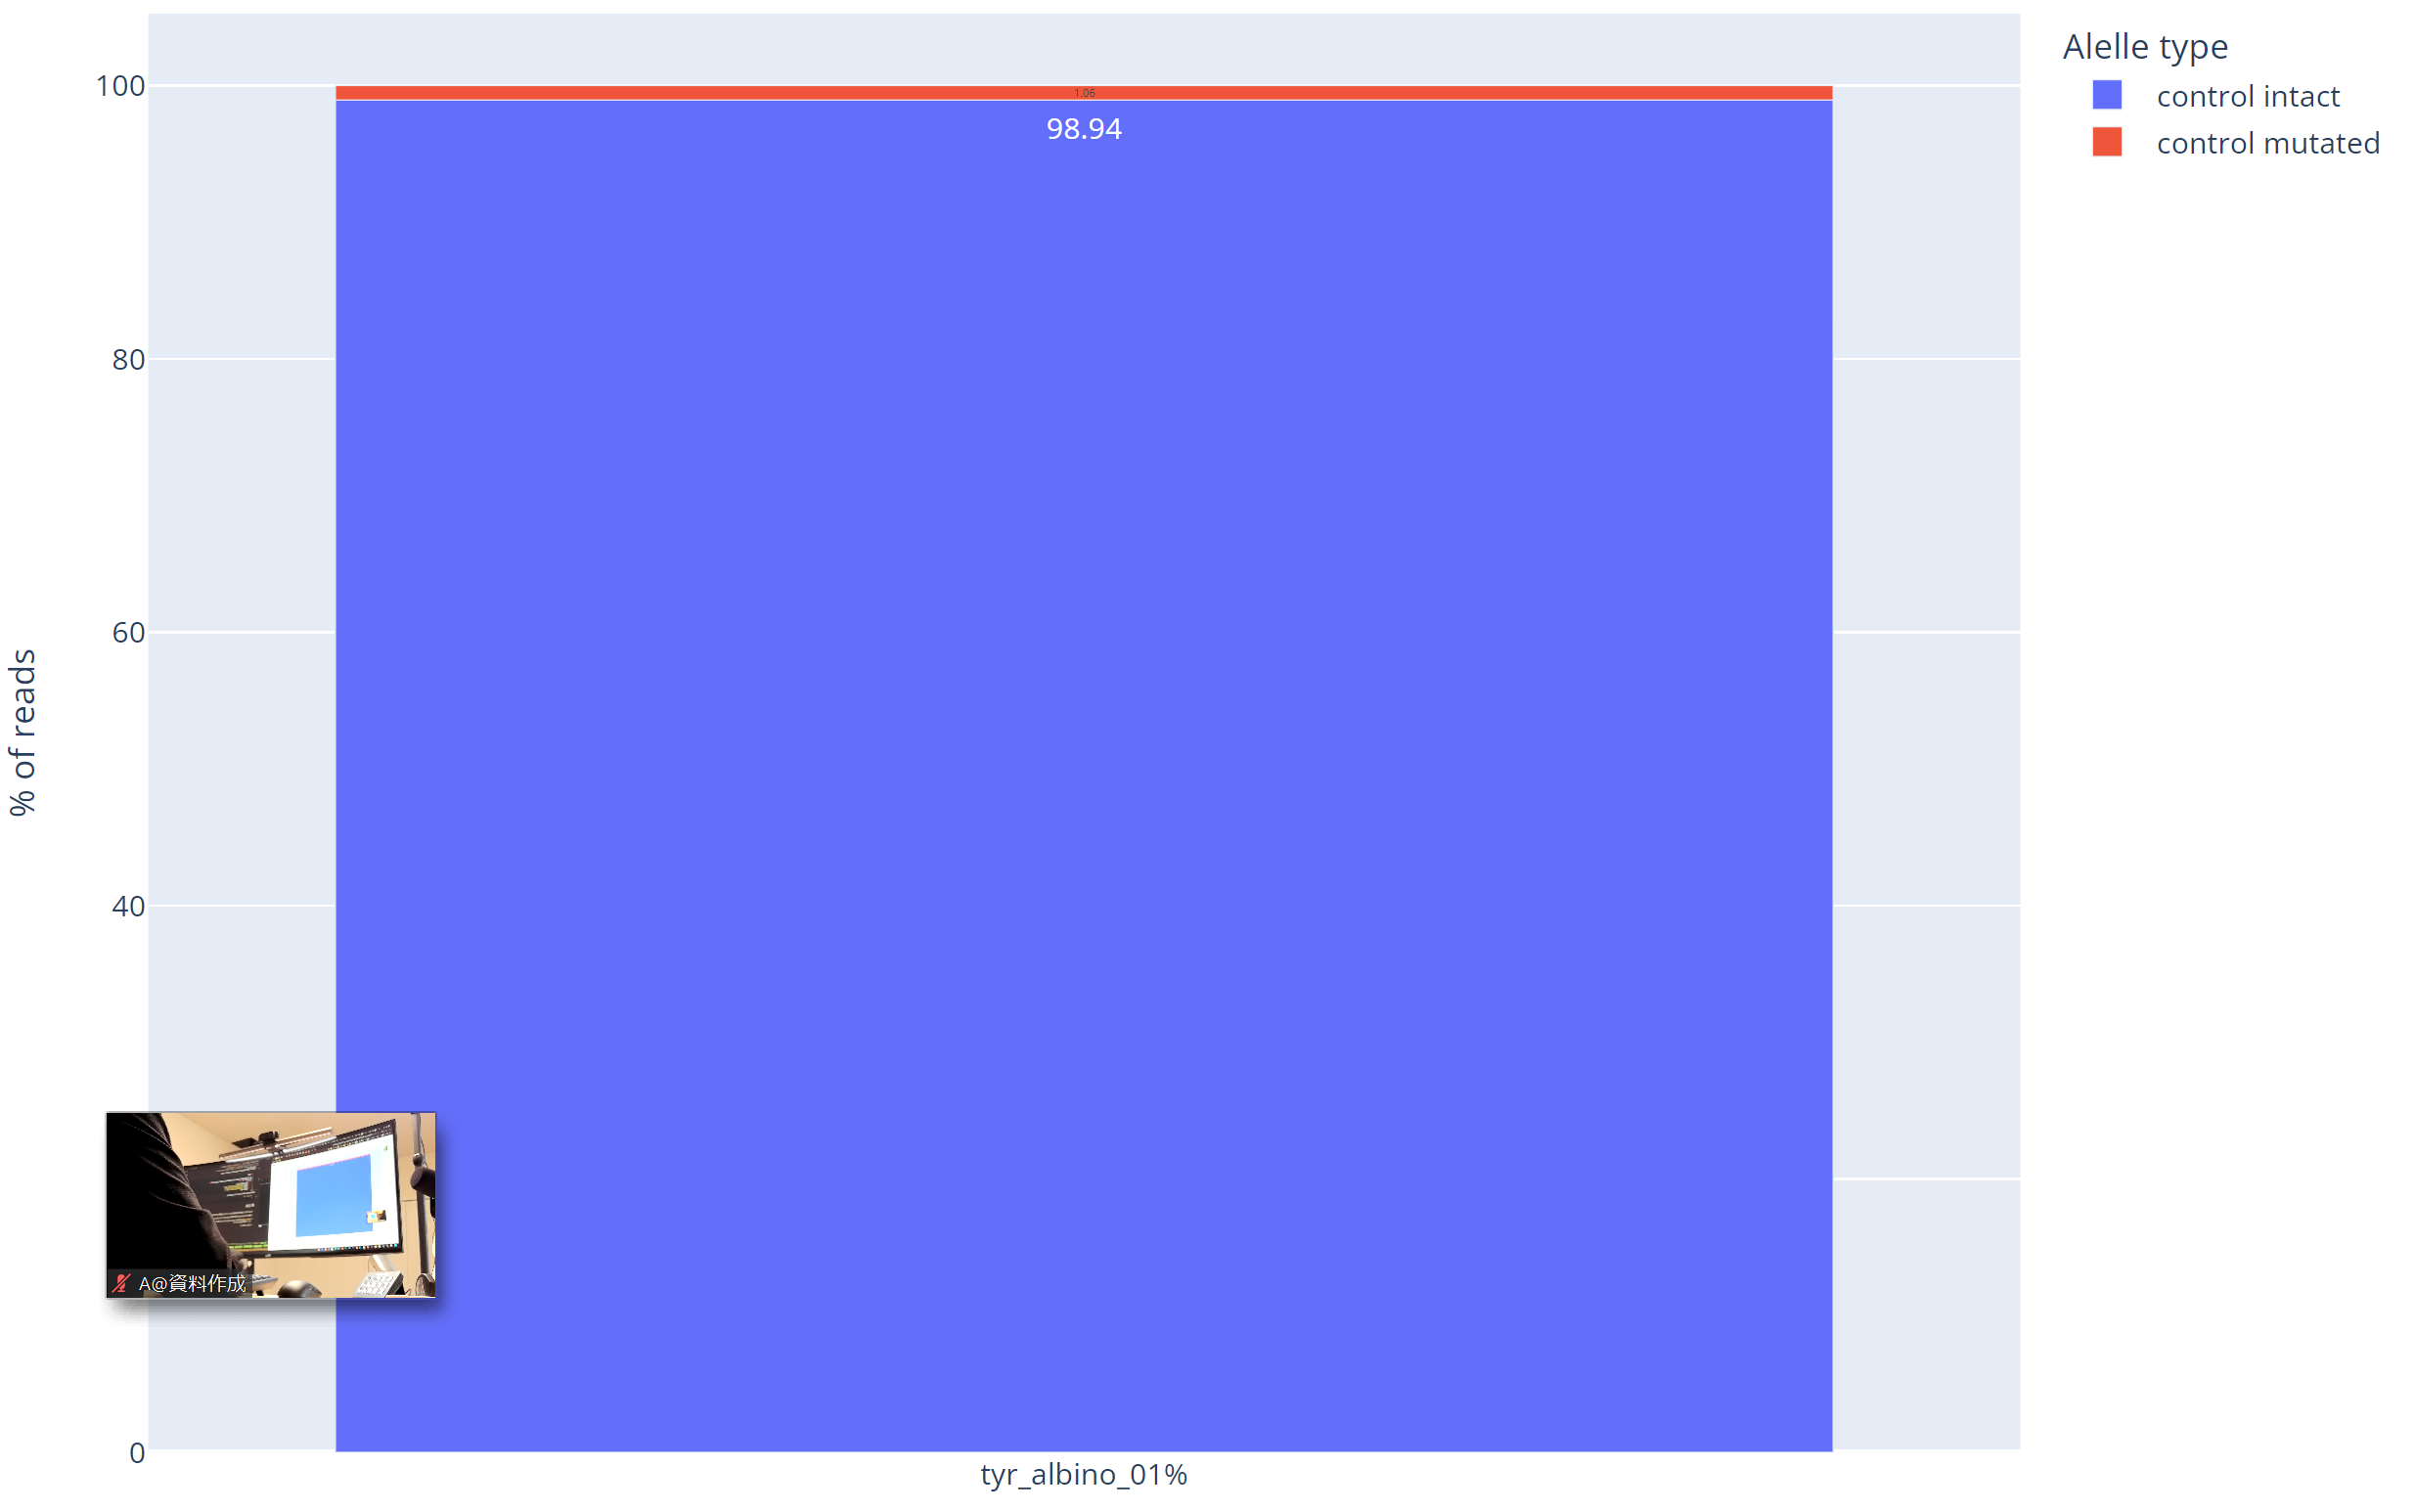

- 次は50%のsingleモードでチャレンジします

In [28]:
%%bash

rm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&
pip install -qe . &&
DAJIN2 \
    --name single_tyr_50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 12, in single_execute
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 119, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 55, in annotate_score
    mutation = list(mutscore.keys())[0]
IndexError: list index out of range


CalledProcessError: Command 'b'\nrm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&\npip install -qe . &&\nDAJIN2 \\\n    --name single_tyr_50 \\\n    --sample "misc/data/tyr_albino_50%.fq.gz" \\\n    --control "misc/data/tyr_control.fq.gz" \\\n    --allele "misc/data/tyr_control.fasta" \\\n    --genome mm10\n'' returned non-zero exit status 1.

- 50%のsingleモードはエラーが再現されました。
- これは次回に回します

# まとめ


- `tyr_01`でのエラーを解決しました
  -  原因は、MUTATION_SCOREが空だったことでした。
    - MUTATION_SCOREが空のときには、リードにLABEL=1を付与することにしました
    - MUTATION_SCOREを計算する閾値を'1%'から'0.5%'に下げることで、目的の点変異を捕捉できました

- 一方で、なぜか`tyr_50`がエラーを出したので、次回はこの対策に取り組みます

# 次に取り組むこと

### Lists

+ **tyr_10%, 01%でうまくいかなかった理由を検討する**

+ [ ] 短いリードの扱いをどうするべきか
+ [ ] `SV`の判定をconsensus callのあとにする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする